Inizio simulazione per 30 generazioni con 2000 agenti...
Gen 0: Avg Cooperation Gene (p) = 0.500
Gen 10: Avg Cooperation Gene (p) = 0.240
Gen 20: Avg Cooperation Gene (p) = 0.169
Simulazione terminata.


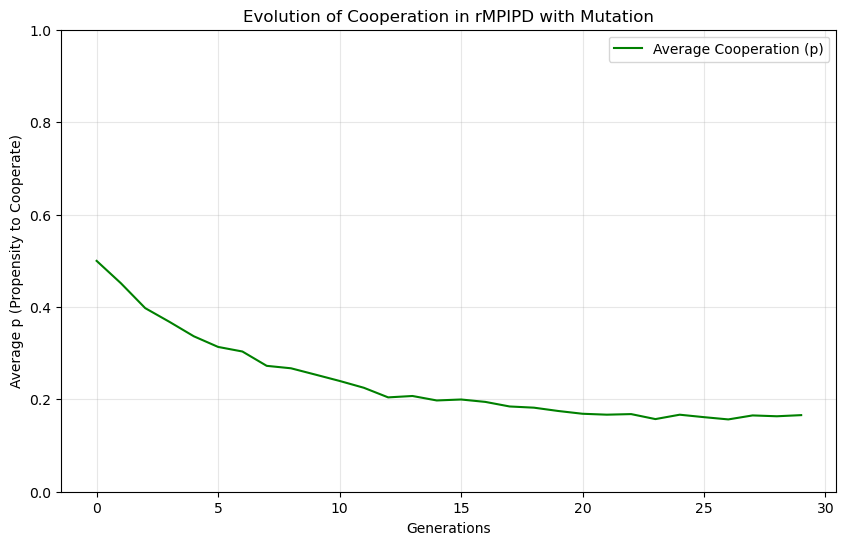

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy

import pandas as pd
from core.match import Match
from core.payoff import PayoffMatrix
from strategies.basic import AlwaysCooperate, AlwaysDefect
from strategies.advanced import TitForTat, Random, MutantRandom

class AgentWrapper:
    """
    Wrapper per associare un punteggio accumulato a una strategia (agente)
    durante una generazione.
    """
    def __init__(self, strategy):
        self.strategy = strategy
        self.score = 0

    def reset_score(self):
        self.score = 0

class EvolutionarySimulation:
    def __init__(self, n_agents=100, rounds_per_match=20, payoff_matrix=None):
        self.n_agents = n_agents
        self.rounds_per_match = rounds_per_match
        self.payoff_matrix = payoff_matrix if payoff_matrix else PayoffMatrix()
        
        # Inizializzazione della popolazione:
        # Creiamo agenti MutantRandom con un "gene" della cooperazione (p) casuale.
        # gamma=0.1 è la probabilità che il gene muti durante la riproduzione.
        self.population = [
            AgentWrapper(MutantRandom(p=np.random.rand(), gamma=0.1)) 
            for _ in range(n_agents)
        ]
        
        # Per tracciare le statistiche
        self.history_avg_p = []

    def run_tournament(self):
        """
        Esegue un torneo Round-Robin o accoppiamenti casuali.
        Qui replichiamo la logica 'random couples' del notebook (rMPIPD).
        """
        # Resetta i punteggi
        for agent in self.population:
            agent.reset_score()
            
        # Mischia la popolazione
        np.random.shuffle(self.population)
        
        # Crea coppie casuali
        # Nota: Se dispari, l'ultimo potrebbe rimanere fuori o giocare col primo
        couples = [
            (self.population[i], self.population[i+1]) 
            for i in range(0, len(self.population) - 1, 2)
        ]

        for agent_a, agent_b in couples:
            # Crea il match usando la tua classe Match
            # Nota: Match richiede istanze di Strategy, quindi passiamo .strategy
            match = Match(agent_a.strategy, agent_b.strategy, self.payoff_matrix)
            
            # Esegue il match
            match.run(self.rounds_per_match)
            
            # Aggiorna i punteggi nel wrapper (Match accumula in score_a/b)
            agent_a.score += match.score_a
            agent_b.score += match.score_b

    def natural_selection(self):
        """
        Seleziona i sopravvissuti per la prossima generazione basandosi sul fitness (score).
        Replica la logica di 'nextGen' del notebook: probabilità proporzionale al payoff.
        """
        total_score = sum(agent.score for agent in self.population)
        
        # Gestione caso limite: se tutti hanno 0 o score negativo (raro col PD standard)
        if total_score <= 0:
            probs = [1.0 / self.n_agents] * self.n_agents
        else:
            probs = [agent.score / total_score for agent in self.population]
        
        # Selezione dei genitori basata sulle probabilità calcolate
        # Usiamo gli indici per selezionare
        selected_indices = np.random.choice(
            range(self.n_agents), 
            size=self.n_agents, 
            p=probs
        )
        
        new_population = []
        for idx in selected_indices:
            # Clona la strategia genitore per la nuova generazione
            parent_strategy = self.population[idx].strategy
            
            # Creiamo una NUOVA istanza per evitare riferimenti condivisi
            # Manteniamo p e gamma del genitore
            child_strategy = MutantRandom(p=parent_strategy.p, gamma=parent_strategy.gamma)
            new_population.append(AgentWrapper(child_strategy))
            
        self.population = new_population

    def mutate(self):
        """
        Applica la mutazione genetica.
        Ogni agente ha una probabilità (gamma) di mutare il proprio gene 'p'.
        """
        for agent in self.population:
            # Il metodo mutate() è già definito nella tua classe MutantRandom
            # Modifica self.p se il lancio del dado < gamma
            agent.strategy.mutate()

    def evolve(self, generations=50):
        """
        Esegue il loop evolutivo completo.
        """
        print(f"Inizio simulazione per {generations} generazioni con {self.n_agents} agenti...")
        
        for gen in range(generations):
            # 1. Combatti
            self.run_tournament()
            
            # 2. Registra statistiche (media della propensione a cooperare 'p')
            avg_p = np.mean([a.strategy.p for a in self.population])
            self.history_avg_p.append(avg_p)
            
            # Stampa progresso ogni 10 generazioni
            if gen % 10 == 0:
                print(f"Gen {gen}: Avg Cooperation Gene (p) = {avg_p:.3f}")
            
            # 3. Selezione Naturale (il più adatto sopravvive e si riproduce)
            self.natural_selection()
            
            # 4. Mutazione (introduce variabilità genetica)
            self.mutate()
            
        print("Simulazione terminata.")

    def plot_results(self):
        """
        Visualizza l'evoluzione del gene della cooperazione.
        """
        plt.figure(figsize=(10, 6))
        plt.plot(self.history_avg_p, label='Average Cooperation (p)', color='green')
        plt.title('Evolution of Cooperation in rMPIPD with Mutation')
        plt.xlabel('Generations')
        plt.ylabel('Average p (Propensity to Cooperate)')
        plt.ylim(0, 1)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

# --- ESECUZIONE DELLA SIMULAZIONE ---

if __name__ == "__main__":
    # Configurazione
    N_PRISONERS = 2000
    GENERATIONS = 30
    MATCH_ROUNDS = 500
    
    # Matrice dei payoff (standard PD)
    # T=5 (Temptation), R=3 (Reward), P=1 (Punishment), S=0 (Sucker)
    payoff_matrix = PayoffMatrix(T=5, R=3, P=1, S=0)
    
    # Istanzia e avvia la simulazione
    sim = EvolutionarySimulation(
        n_agents=N_PRISONERS, 
        rounds_per_match=MATCH_ROUNDS, 
        payoff_matrix=payoff_matrix
    )
    
    sim.evolve(generations=GENERATIONS)
    sim.plot_results()